# Project 3: Web APIs & NLP
### Notebook 03 - Modeling


_Author: Joe Serigano (jserigano4@gmail.com)_

---

**Objectives:**
- Create NLP models to predict original subreddit of a post title from our cleaned data.
- Determine best fitting parameters for each model using GridSearchCV.
- Save best-fitting parameters and results for each model to a DataFrame.

In [1]:
# Import libaries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score

# We are dealing with large data sets, so setting max number of column and row displays to be unlimited
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter("ignore")

In [2]:
# Reading in the cleaned data
df = pd.read_csv('data/protips_cleaned.csv')

In [3]:
df.head()

,subreddit,title,title_word_count,title_clean
0,1,If you are as outraged as I am about the overt...,24,"If outraged I overturning Roe v Wade, join mak..."
1,1,Doing things when you don't want to do them is...,32,"Doing things want skill practice, take advanta..."
2,1,Dedicate a credit card to only subscription se...,21,Dedicate credit card subscription services. If...
3,1,Like to have a flutter but gambling is too exp...,12,Like flutter gambling expensive? Try ‘micro-ga...
4,1,Enraged by RvW and feeling powerless? Consider...,21,Enraged RvW feeling powerless? Consider joinin...


We will be using a parameter grid to find the optimal model. This will include vectorizing the features using CountVectorizer() and TfidfVectorizer() with cleaned data, lemmatized data, and stemmed data. The functions below, which we used in the previous notebook, will be used in our modeling to handle this. 

In [4]:
# Function for lemmatizing
def lemmatize_title(title):

    # split into words
    split_title = title.split()

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize and rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_title])

In [5]:
def stem_title(title):

    # split into words
    split_title = title.split()
    
    # instantiate stemmer
    stemmer = PorterStemmer()

    # stem and rejoin
    return ' '.join([stemmer.stem(word) for word in split_title])

## Baseline model:

Our baseline model accuracy is the probability that a given post will come from our target subreddit, r/LifeProTips. Our baseline accuracy is 50.5% in this case. Hopefully we will be able to create some models that score better than this!

In [6]:
df['subreddit'].value_counts(normalize = True)

1    0.504693
0    0.495307
Name: subreddit, dtype: float64

## Modelling:

Next, we will split our data into our features (X) and our target (y) variables and perform a train/test split. 

In [7]:
X = df['title_clean']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [34]:
print(y_train.shape)
print(y_test.shape)

(15502,)
(5168,)


We will create a function to make it easier to run many different models with different combinations of vectorizers and estimators.

First, we will define the parameters to be used for each.

In [8]:
# Vectorizer parameters:

cvec_params = {
    'cvec__preprocessor' : [None, lemmatize_title, stem_title],
    'cvec__max_features': [None, 5_000],
    'cvec__max_df': [0.5, 0.9],
    'cvec__ngram_range':[(1,1), (1,2)],
}

tvec_params = {
    'tvec__preprocessor' : [None, lemmatize_title, stem_title],
    'tvec__max_features': [None, 5_000],
    'tvec__max_df': [0.5, 0.9],
    'tvec__ngram_range':[(1,1), (1,2)]
}

In [10]:
# Model parameters:

lr_params = {
    'lr__penalty':['l1','l2'],
    'lr__C':[0.1, 1, 10],
}

knn_params = {'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance']}

nb_params = {
    'nb__alpha': [0.1, 1, 10]
}

rf_params = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [None, 5],
    'rf__min_samples_leaf': [1, 5]
}

ada_params = {
    'ada__n_estimators': [50, 100],
    'ada__learning_rate': [0.5, 1.0]
}

gb_params = {
    'gb__max_depth': [3, 4],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.5, 1.0]
}

In [11]:
def NLP_model(vec_inst, vectorizer, mod_inst, model, vec_params, mod_params):
    '''
    Function to run NLP model given vectorizer, estimator, and parameters for GridSearchCV. 
    This function will:
    - Use vectorizer to transform input data
    - Fit training data with model
    - Generate model predictions
    - Evaluate model performance with various metrics
    - Print classification report and plot confusion matrix
    - Output metric results to DataFrame
    **************
    Input params:
    vec_inst: String of vectorizer abbreviation
    vectorizer: Vectorizer to use with GridsearchCV model
    mod_inst: String of model abbreviation
    model: Estimator to use with GridsearchCV model  
    vec_params: Parameters to use for vectorizer
    mod_params: Parameters to use for estimator
    **************
    '''
    pipe = Pipeline([
        (vec_inst, vectorizer),
        (mod_inst, model)])
    
    gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params})
    gs.fit(X_train, y_train)
    
    print('*'*80)
    print(f'MODEL = {model}, VECTORIZER = {vectorizer}')
    print('*'*80)
    print(f'Best fitting parameters: {gs.best_params_}\n')
    print(f'Best score: {round(gs.best_score_, 3)}')
    print(f'Test score: {round(gs.score(X_test, y_test), 3)}\n')
    
    # Get predictions
    preds = gs.predict(X_test)
    
    print('Classification report:')
    print(classification_report(y_test, preds))
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    
    # Save best model results to Dataframe
    df = pd.DataFrame()
    df['model_vec'] = [f'{mod_inst}_{vec_inst}']
    df['best_params'] = [gs.best_params_]
    df['train_score'] = gs.best_score_
    df['test_score'] = gs.score(X_test, y_test)
    df['sensitivity'] =  tp / (tp + fn)
    df['specificity'] = tn / (tn + fp)
    df['precision'] = tp / (tp + fp)
    df['f1_score'] = f1_score(y_test, preds)
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['tp'] = tp
    
    return df

In [12]:
# Define list of DataFrames to save all best model outputs
df_all = []

We will use GridSearchCV to find the best parameter values for each combination of vectorizer and estimator.

We will use the vectorizers CounterVectorizer(), Tfidfvectorizer() with preprocessing parameters that include (among others) tokenized, lemmatized, and stemmed versions of the features.

We will use the estimators LogisticRegression(), KNeighborsClassifier(), MultinomialNB(), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier().

All together there will be 12 models. We will run them below and print some results. The results of the best fitting model for each grid search will be saved to a DataFrame.

## 1. LogisticRegression(), CountVectorizer():

********************************************************************************
MODEL = LogisticRegression(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'lr__C': 1, 'lr__penalty': 'l2'}

Best score: 0.742
Test score: 0.753

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      2560
           1       0.76      0.75      0.75      2608

    accuracy                           0.75      5168
   macro avg       0.75      0.75      0.75      5168
weighted avg       0.75      0.75      0.75      5168



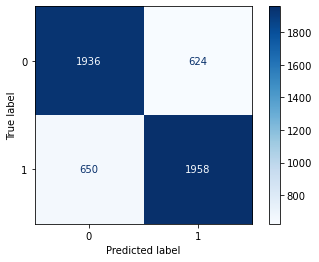

In [13]:
lr_cvec = NLP_model('cvec', CountVectorizer(), 'lr', LogisticRegression(), cvec_params, lr_params)
lr_cvec.head().T

df_all.append(lr_cvec)

## 2. LogisticRegression(), TfidfVectorizer()

********************************************************************************
MODEL = LogisticRegression(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'lr__C': 10, 'lr__penalty': 'l2', 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}

Best score: 0.748
Test score: 0.757

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2560
           1       0.76      0.77      0.76      2608

    accuracy                           0.76      5168
   macro avg       0.76      0.76      0.76      5168
weighted avg       0.76      0.76      0.76      5168



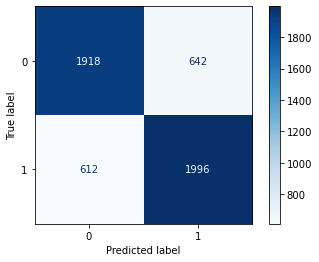

In [14]:
lr_tvec = NLP_model('tvec', TfidfVectorizer(), 'lr', LogisticRegression(), tvec_params, lr_params)
lr_tvec.head().T

df_all.append(lr_tvec)

## 3. KNeighborsClassifier(), CountVectorizer()

********************************************************************************
MODEL = KNeighborsClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

Best score: 0.595
Test score: 0.598

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.79      0.66      2560
           1       0.67      0.41      0.51      2608

    accuracy                           0.60      5168
   macro avg       0.62      0.60      0.58      5168
weighted avg       0.62      0.60      0.58      5168



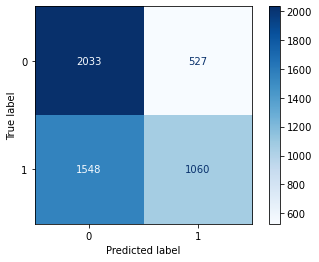

In [15]:
knn_cvec = NLP_model('cvec', CountVectorizer(), 'knn', KNeighborsClassifier(), cvec_params, knn_params)
knn_cvec.head().T

df_all.append(knn_cvec)

# 4. KNeighborsClassifier(), TfidfVectorizer()

********************************************************************************
MODEL = KNeighborsClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance', 'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__preprocessor': None}

Best score: 0.576
Test score: 0.589

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.93      0.69      2560
           1       0.78      0.26      0.39      2608

    accuracy                           0.59      5168
   macro avg       0.66      0.59      0.54      5168
weighted avg       0.67      0.59      0.54      5168



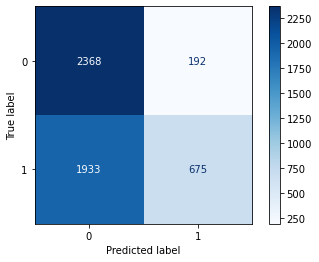

In [16]:
knn_tvec = NLP_model('tvec', TfidfVectorizer(), 'knn', KNeighborsClassifier(), tvec_params, knn_params)
knn_tvec.head().T

df_all.append(knn_tvec)

# 5. MultinomialNB(), CountVectorizer()

********************************************************************************
MODEL = MultinomialNB(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'nb__alpha': 1}

Best score: 0.754
Test score: 0.752

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2560
           1       0.75      0.76      0.75      2608

    accuracy                           0.75      5168
   macro avg       0.75      0.75      0.75      5168
weighted avg       0.75      0.75      0.75      5168



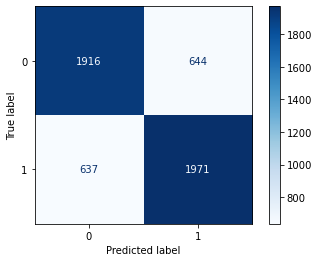

In [17]:
nb_cvec = NLP_model('cvec', CountVectorizer(), 'nb', MultinomialNB(), cvec_params, nb_params)
nb_cvec.head().T

df_all.append(nb_cvec)

# 6. MultinomialNB(), TfidfVectorizer()

********************************************************************************
MODEL = MultinomialNB(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}

Best score: 0.754
Test score: 0.756

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2560
           1       0.75      0.77      0.76      2608

    accuracy                           0.76      5168
   macro avg       0.76      0.76      0.76      5168
weighted avg       0.76      0.76      0.76      5168



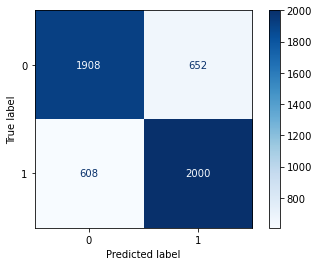

In [18]:
nb_tvec = NLP_model('tvec', TfidfVectorizer(), 'nb', MultinomialNB(), tvec_params, nb_params)
nb_tvec.head().T

df_all.append(nb_tvec)

# 7. RandomForestClassifier(), CountVectorizer()

********************************************************************************
MODEL = RandomForestClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}

Best score: 0.715
Test score: 0.725

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      2560
           1       0.75      0.68      0.72      2608

    accuracy                           0.73      5168
   macro avg       0.73      0.73      0.72      5168
weighted avg       0.73      0.73      0.72      5168



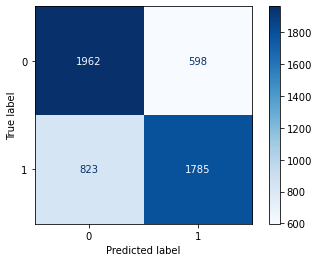

In [19]:
rf_cvec = NLP_model('cvec', CountVectorizer(), 'rf', RandomForestClassifier(), cvec_params, rf_params)
rf_cvec.head().T

df_all.append(rf_cvec)

# 8. RandomForestClassifier(), TfidfVectorizer()

********************************************************************************
MODEL = RandomForestClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 1), 'tvec__preprocessor': None}

Best score: 0.71
Test score: 0.727

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      2560
           1       0.74      0.70      0.72      2608

    accuracy                           0.73      5168
   macro avg       0.73      0.73      0.73      5168
weighted avg       0.73      0.73      0.73      5168



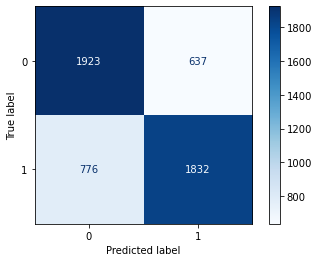

In [20]:
rf_tvec = NLP_model('tvec', TfidfVectorizer(), 'rf', RandomForestClassifier(), tvec_params, rf_params)
rf_tvec.head().T

df_all.append(rf_tvec)

## 9. AdaBoostClassifier(), CountVectorizer()

********************************************************************************
MODEL = AdaBoostClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'ada__learning_rate': 0.5, 'ada__n_estimators': 100, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__preprocessor': None}

Best score: 0.632
Test score: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56      2560
           1       0.61      0.81      0.69      2608

    accuracy                           0.64      5168
   macro avg       0.66      0.64      0.63      5168
weighted avg       0.66      0.64      0.63      5168



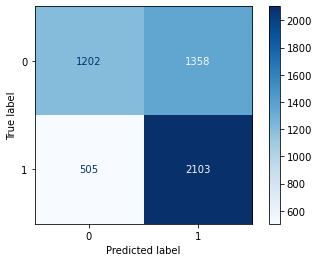

In [21]:
ada_cvec = NLP_model('cvec', CountVectorizer(), 'ada', AdaBoostClassifier(), cvec_params, ada_params)
ada_cvec.head().T

df_all.append(ada_cvec)

## 10. AdaBoostClassifier(), TfidfVectorizer()

********************************************************************************
MODEL = AdaBoostClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'ada__learning_rate': 1.0, 'ada__n_estimators': 100, 'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}

Best score: 0.639
Test score: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.48      0.57      2560
           1       0.61      0.80      0.69      2608

    accuracy                           0.64      5168
   macro avg       0.65      0.64      0.63      5168
weighted avg       0.65      0.64      0.63      5168



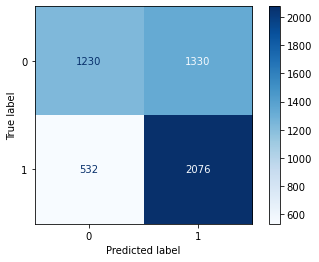

In [22]:
ada_tvec = NLP_model('tvec', TfidfVectorizer(), 'ada', AdaBoostClassifier(), tvec_params, ada_params)
ada_tvec.head().T

df_all.append(ada_tvec)

# 11. GradientBoostingClassifier(), CountVectorizer()

********************************************************************************
MODEL = GradientBoostingClassifier(), VECTORIZER = CountVectorizer()
********************************************************************************
Best fitting parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 200}

Best score: 0.694
Test score: 0.688

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      2560
           1       0.67      0.76      0.71      2608

    accuracy                           0.69      5168
   macro avg       0.69      0.69      0.69      5168
weighted avg       0.69      0.69      0.69      5168



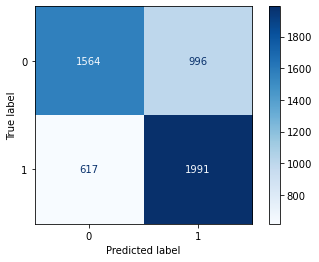

In [23]:
gb_cvec = NLP_model('cvec', CountVectorizer(), 'gb', GradientBoostingClassifier(), cvec_params, gb_params)
gb_cvec.head().T

df_all.append(gb_cvec)

# 12. GradientBoostingClassifier(), TfidfVectorizer()

********************************************************************************
MODEL = GradientBoostingClassifier(), VECTORIZER = TfidfVectorizer()
********************************************************************************
Best fitting parameters: {'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 1), 'tvec__preprocessor': None}

Best score: 0.687
Test score: 0.68

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66      2560
           1       0.67      0.72      0.70      2608

    accuracy                           0.68      5168
   macro avg       0.68      0.68      0.68      5168
weighted avg       0.68      0.68      0.68      5168



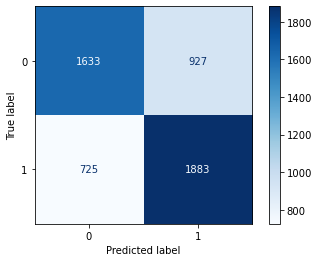

In [24]:
gb_tvec = NLP_model('tvec', TfidfVectorizer(), 'gb', GradientBoostingClassifier(), tvec_params, gb_params)
gb_tvec.head().T

df_all.append(gb_tvec)

In [25]:
full_df = pd.concat(df_all)

## Results:

In [31]:
#full_df.to_csv('data/model_results.csv', index=False)

In [35]:
pd.set_option('display.max_colwidth', None)
full_df.sort_values(by=['test_score'], ascending=False).reset_index(drop=True)

,model_vec,best_params,train_score,test_score,sensitivity,specificity,precision,f1_score,tn,fp,fn,tp
0,lr_tvec,"{'lr__C': 10, 'lr__penalty': 'l2', 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}",0.748420,0.757353,0.765337,0.749219,0.756634,0.760961,1918,642,612,1996
1,nb_tvec,"{'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}",0.753903,0.756192,0.766871,0.745313,0.754148,0.760456,1908,652,608,2000
2,lr_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'lr__C': 1, 'lr__penalty': 'l2'}",0.742098,0.753483,0.750767,0.756250,0.758327,0.754528,1936,624,650,1958
3,nb_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'nb__alpha': 1}",0.754032,0.752128,0.755752,0.748437,0.753728,0.754739,1916,644,637,1971
4,rf_tvec,"{'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 1), 'tvec__preprocessor': None}",0.710037,0.726587,0.702454,0.751172,0.742001,0.721686,1923,637,776,1832
5,rf_cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}",0.714811,0.725039,0.684433,0.766406,0.749056,0.715288,1962,598,823,1785
6,gb_cvec,"{'cvec__max_df': 0.5, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__preprocessor': None, 'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 200}",0.694104,0.687887,0.763420,0.610938,0.666555,0.711707,1564,996,617,1991
7,gb_tvec,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__ngram_range': (1, 1), 'tvec__preprocessor': None}",0.686621,0.680341,0.722009,0.637891,0.670107,0.695090,1633,927,725,1883
8,ada_tvec,"{'ada__learning_rate': 1.0, 'ada__n_estimators': 100, 'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__preprocessor': None}",0.639272,0.639706,0.796012,0.480469,0.609513,0.690389,1230,1330,532,2076
9,ada_cvec,"{'ada__learning_rate': 0.5, 'ada__n_estimators': 100, 'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'cvec__preprocessor': None}",0.631596,0.639512,0.806365,0.469531,0.607628,0.693030,1202,1358,505,2103


Overall our models did okay. They all outperformed the baseline null model of 50.4% accuracy, which is reassuring, but the overall accuracy is still not as high as I was hoping it would be. Our train and test scores for each model are very similar, indicating that our models are not overfit.

Our best model is a Logistic Regression model with L2 (Ridge) regularization and TfidfVectorizer with no preprocessing of the words (i.e., no lemmatizing or stemming). This model accurately predicted the subreddit classification of 75.7% of the test data based on our input features. 

It should be noted that the scores for our next best-fitting models are very similar to the best model. These models are a Multinomial Naive Bayes model with TfidfVectorizer and another Logistic Regression model with L2 regularization and CountVectorizer. 